In [1]:
#if it does not download -> run this and restart kernel
pip install --upgrade --no-cache-dir gdown


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import gdown

def download_file(file_id, file_path):
  if not os.path.exists(file_path):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

dblp_file_id = '1FfXoF1C2VEJ3dGxJRwtGUO4GyW5ZmSeO'
dblp_file_path = 'Citations-files/dblp.txt'
acm_file_id = '1cDFohEvRMGF8OAN-gRPQeg5sHoXVDoi2'
acm_file_path = 'Citations-files/acm.txt'

download_file(dblp_file_id, dblp_file_path)
download_file(acm_file_id, acm_file_path)

In [17]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import uuid
import string
from nltk.stem.snowball import SnowballStemmer
import re

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data_list = []
    current_entry = {}
    for line in lines:
        if line.startswith("#*"):
            current_entry['paper_title'] = line[2:].strip()
        elif line.startswith("#@"):
            current_entry['author_names'] = line[2:].strip()
        elif line.startswith("#t"):
            current_entry['year'] = line[2:].strip()
        elif line.startswith("#c"):
            current_entry['publication_venue'] = line[2:].strip()
        elif line.startswith("#index"):
            current_entry['index'] = line[6:].strip()
        elif line.strip() == "":
            data_list.append(current_entry)
            current_entry = {}

    return pd.DataFrame(data_list)


# fill years before filtering
def filling_years(dataframe, filling_method):
    filling_method = filling_method.lower()
    if filling_method not in ['median', 'mean', 'mode']:
        raise ValueError('Invalid filling method')
    if dataframe['year'].isnull().sum().any():
        if(filling_method == 'median'):
            median_year = dataframe['year'].median()
            dataframe['year'] = dataframe['year'].fillna(median_year)
        elif(filling_method == 'mean'):
            mean_year = dataframe['year'].mean()
            dataframe['year'] = dataframe['year'].fillna(mean_year)
        else:
            mode_year = dataframe['year'].mode()
            dataframe['year'] = dataframe['year'].fillna(mode_year)

    return dataframe

def distribution_of_year(dataframe, ylim, yticks, xlim, xticks):
    year_array = dataframe['year'].to_numpy()

    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.xlim(xlim)
    plt.xticks(xticks)
   
    # Calculate skewness
    skewness = stats.skew(year_array)
    # Calculate kurtosis
    kurtosis = stats.kurtosis(year_array)
     # Print the distribution
    print(f'Skewness: {skewness:.3f}')
    print(f'Kurtosis: {kurtosis:.3f}')

    plt.hist(year_array)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Distribution of years')
    plt.show()

    # Interpretation of skewness and kurtosis
    # Skewness used Treshold 0.1, because its commonly used
    # Kurtosis uses a Treshold of 3 where 3 = normal, >3 peakend and <3 = flat and I consider minimal differences up to 2 still as somewhat normal
    # therefore 2.8 and 3.2
    if skewness < 0.1 and 2.8 <= kurtosis <= 3.2 :
        print('The distribution is approximately normal.')
    elif skewness > 0.1:
        print('The distribution is skewed to the right.')
    elif skewness < -0.1:
        print('The distribution is skewed to the left.')
    if kurtosis > 3.2:
        print('The distribution is peaked.')
    elif kurtosis < 2.8:
        print('The distribution is flat.')

default_values = {'paper_title' : 'Untitled', 'author_names' : 'unamed'}

# Removal off duplicates and filling NaN values for paper_title and author_names (after filtering)
def cleansing_data(dataframe):
    if(dataframe.isnull().sum().any()):
           dataframe.fillna(default_values, inplace=True)
    if(dataframe['index'].isnull().sum().any()):
        unique_values = [str(uuid.uuid4().hex) for i in range(dataframe['index'].isnull().sum())]
        dataframe.loc[dataframe['index'].isnull(), 'index'] = unique_values
    return dataframe

def remove_punctuation_from_columns(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].replace(to_replace=f'[{string.punctuation}]', value='', regex=True)
    return df

#def clean_text(dataframe):
#    return dataframe.map(lambda x: x.lower().strip() if isinstance(x, str) else x)

def clean_text(dataframe):
    return dataframe.map(lambda x: re.sub(r'\s+', ' ', str(x).lower().strip()) if isinstance(x, str) else x)

def custom_stemmer(word):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(word)

def apply_stem(dataframe, columns):
    for col in columns:
        dataframe[col] = dataframe[col].apply(lambda x: ' '.join([custom_stemmer(word) for word in x.split()]))
    return dataframe




  

In [8]:
dblp_data = read_file(dblp_file_path)
dblp_data['year'] = pd.to_numeric(dblp_data['year'], errors='coerce')
acm_data = read_file(acm_file_path)
acm_data['year'] = pd.to_numeric(acm_data['year'], errors='coerce')

Skewness: -8.690
Kurtosis: 1705.600


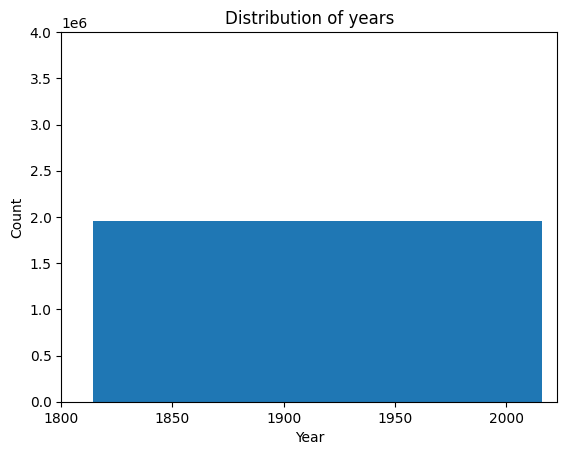

The distribution is skewed to the left.
The distribution is peaked.


In [9]:
dblp_data_without_NaN_Years = dblp_data.dropna(subset=['year'])
ylim = (0, 4000000)
yticks = (np.arange(0, 4000001, 500000))
xlim = (1800, 2023)
xticks = (np.arange(1800, 2024, 50))
distribution_of_year(dblp_data_without_NaN_Years, ylim, yticks, xlim, xticks) 

Skewness: -1.289
Kurtosis: 1.864


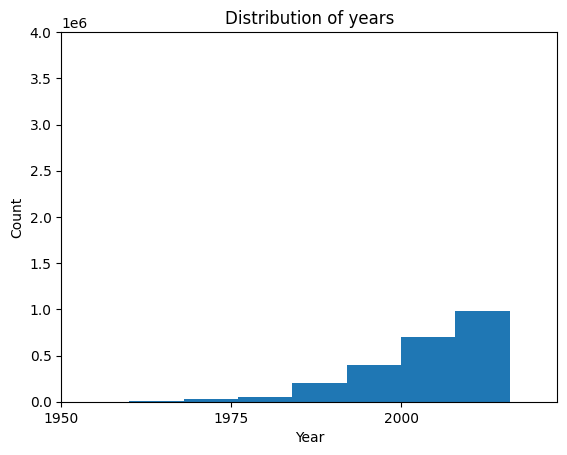

The distribution is skewed to the left.
The distribution is flat.


In [10]:
acm_data_without_NaN_Years = acm_data.dropna(subset=['year'])
ylim = (0, 40000)
yticks = (np.arange(0, 4000001, 500000))
xlim = (1950, 2023)
xticks = (np.arange(1950, 2024, 25))
distribution_of_year(acm_data_without_NaN_Years, ylim, yticks , xlim, xticks) 

In [21]:
# filling years cause it's important for filtering
dlbp_data = filling_years(dblp_data, 'mean')
acm_data = filling_years(acm_data, 'mean')

#filter
dblp_data = dblp_data[(dblp_data['year'] >= 1995) & (dblp_data['year'] <= 2004) &
                     (dblp_data['publication_venue'].str.contains('SIGMOD|VLDB', case=False))]
acm_data = acm_data[(acm_data['year'] >= 1995) & (acm_data['year'] <= 2004) &
                     (acm_data['publication_venue'].str.contains('SIGMOD|VLDB', case=False))]

# remove duplicates, fill NaN values for Authors and Paper and generate unique ID for NaN ones
dblp_data = cleansing_data(dblp_data)
acm_data = cleansing_data(acm_data)

# remove punctations
columns_to_process = ["paper_title", "publication_venue"]
dblp_data = remove_punctuation_from_columns(dblp_data, columns_to_process)
acm_data = remove_punctuation_from_columns(acm_data, columns_to_process)


# lower it and strip
dblp_data = clean_text(dblp_data)
acm_data = clean_text(acm_data)

# stem columns
# comment out if you want without stem
dblp_data = apply_stem(dblp_data, columns_to_process)
acm_data = apply_stem(acm_data, columns_to_process)

# year as int
dblp_data['year'] = dblp_data['year'].astype(int)
acm_data['year'] = acm_data['year'].astype(int)


In [24]:
# change order
order = ['paper_title', 'author_names', 'year', 'publication_venue', 'index']
dblp_data = dblp_data[order]
acm_data = acm_data[order]

# specify the path and save as CSV
output_csv_path = 'CSV-files/dblp.csv'
dblp_data.to_csv(output_csv_path, index=False)

output_csv_path = 'CSV-files/acm.csv'
acm_data.to_csv(output_csv_path, index=False)

Da stem im Nachhinein verwendet wurde und schon bearbeitet csv gibt wurden die mit stem extra mit _stem benannt. Wenn das ganze aber ausgerufen wird, dann wird das normale mit stem ersetzt außer kommentierst es aus oder änderst kurz den path name